In [1]:
!pip install scikit-learn
!pip install pandas
!pip install datasets
!pip install transformers


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

import pandas as pd
df = pd.read_csv("train_all_tasks.csv")
from datasets import Dataset
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

lista_tekst = df["text"]
lista_label = df["label_sexist"]

for train_index, test_index in sss.split(lista_tekst, lista_label):
    X_train, X_test = lista_tekst[train_index], lista_tekst[test_index]
    y_train, y_test = lista_label[train_index], lista_label[test_index]
    d_train = {"text": X_train, "label": y_train}
    df_train = pd.DataFrame(d_train)
    d_test = {"text": X_test, "label": y_test}
    df_test = pd.DataFrame(d_test)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)

lista_tekst = np.array(df_train["text"])
lista_label = np.array(df_train["label"])

for train_index, valid_index in sss.split(lista_tekst, lista_label):
    X_train, X_valid = lista_tekst[train_index], lista_tekst[valid_index]
    y_train, y_valid = lista_label[train_index], lista_label[valid_index]
    d_train = {"text": X_train, "label": y_train}
    df_train = pd.DataFrame(d_train)
    d_valid = {"text": X_valid, "label": y_valid}
    df_valid = pd.DataFrame(d_valid)

print(len(df_test), len(df_valid), len(df_train))
df = {"train": df_train, "test": df_test, "valid": df_valid}

2800 1400 9800


In [4]:
#df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
#df = {"train": df_train, "test": df_test}

def sentiment_to_label(sentiment):
    return 1 if sentiment == "sexist" else 0
print(df_train)
for split in df:
    df[split]["label"] = df[split]["label"].apply(sentiment_to_label)
    #df[split] = df[split].drop("label_sexist", axis=1)
    #df[split] = Dataset.from_pandas(df[split])
print(df_train)

                                                   text       label
0     #Germany, Rheinbach - x2 men indecently assaul...  not sexist
1     Also if you know any Corbyn supporters, ask th...  not sexist
2     I realized women will never be attracted to me...      sexist
3     Be you straight, gay, born as a woman, black, ...  not sexist
4                                A man makes the table.      sexist
...                                                 ...         ...
9795  Nah that’s rape/sexual molestation/gross. Quot...  not sexist
9796  This is Phila Ndwandwe killed by the apartheid...  not sexist
9797  As long as he's tall, women will love his "bet...      sexist
9798  Sergei something uncanny about this picture. I...  not sexist
9799  [USER] Don't be embarrassed. They aren't women...      sexist

[9800 rows x 2 columns]
                                                   text  label
0     #Germany, Rheinbach - x2 men indecently assaul...      0
1     Also if you know any Corbyn

In [5]:
print(type(df_train))

<class 'pandas.core.frame.DataFrame'>


In [6]:
def evaluate(y_test, y_test_pred):
    # mjerit ćemo predviđanje modela pomoću matrice konfuzije
    # te sljedećih metrika: preciznost, odziv, f1 (https://en.wikipedia.org/wiki/Precision_and_recall)
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_fscore_support

    print(classification_report(y_test, y_test_pred))

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average="micro"
    )
    print(f"Precision: {precision:6.2f}")
    print(f"   Recall: {recall:6.2f}")
    print(f"       F1: {f1:6.2f}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.show()
    return precision, recall, f1

In [7]:
from transformers import AutoModelForSequenceClassification

# Ovime smo definirali da želimo model bert-base-uncased (bert s 12 enkodera koji ne razlikuje mala i velika slova)
# Također smo definirali da želimo BERT model koji može svrstati tekst u 2 klase
# Dodajemo sloj iznad 12-tog enkodera koji omogućava klasifikaciju (taj sloj se zove potpuno povezani sloj)
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
)

from transformers import AutoTokenizer

# učitajmo tokenizator za model koji želimo koristiti (svaki transformer ima svoj tokenizator)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model2 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
if torch.cuda.is_available():
  model2.cuda()

from transformers import BertTokenizer
tokenizer2 = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
input_ids = {
    "train": [],
    "valid": [],
    "test": []
}
attention_masks = {
    "train": [],
    "valid": [],
    "test": []
}
labels = {
    "train": [],
    "valid": [],
    "test": []
}
for i in input_ids:
  labels[i] = df[i]["label"]

for i in input_ids:
  for sent in df[i]["text"]:
    encoded_dict = tokenizer2.encode_plus(
        sent, # Sentence to encode.
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = 128,
        truncation=True, # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True,   # Construct attn. masks.
        return_tensors = 'pt',
    )
    input_ids[i].append(encoded_dict['input_ids'])
    attention_masks[i].append(encoded_dict['attention_mask'])

for i in input_ids:
  input_ids[i] = torch.cat(input_ids[i], dim=0)
  attention_masks[i] = torch.cat(attention_masks[i], dim=0)
  labels[i] = torch.tensor(np.array(labels[i]))

print(df["train"]["text"][0])
print(input_ids["train"][0])
print(attention_masks["train"][0])
print(labels["train"][0])

C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#Germany, Rheinbach - x2 men indecently assault 36-yo female cyclist, after impeding her way & forcing her to crash / woman injured / witness information - perps: "a foreign appearance" [URL]
tensor([  101,  1001,  2762,  1010,  1054, 26496,  7693,  1011,  1060,  2475,
         2273, 27427, 26005, 20630,  6101,  4029,  1011, 10930,  2931, 14199,
         1010,  2044, 17727, 17819,  2014,  2126,  1004,  6932,  2014,  2000,
         5823,  1013,  2450,  5229,  1013,  7409,  2592,  1011,  2566,  4523,
         1024,  1000,  1037,  3097,  3311,  1000,  1031, 24471,  2140,  1033,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,

In [11]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

dataset = {
    "train": [],
    "valid": [],
    "test": []
}

for i in dataset:
  dataset[i] = TensorDataset(input_ids[i], attention_masks[i], labels[i])


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:10.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Batch   120  of    613.    Elapsed: 0:00:31.
  Batch   160  of    613.    Elapsed: 0:00:42.
  Batch   200  of    613.    Elapsed: 0:00:52.
  Batch   240  of    613.    Elapsed: 0:01:03.
  Batch   280  of    613.    Elapsed: 0:01:13.
  Batch   320  of    613.    Elapsed: 0:01:24.
  Batch   360  of    613.    Elapsed: 0:01:34.
  Batch   400  of    613.    Elapsed: 0:01:45.
  Batch   440  of    613.    Elapsed: 0:01:56.
  Batch   480  of    613.    Elapsed: 0:02:06.
  Batch   520  of    613.    Elapsed: 0:02:17.
  Batch   560  of    613.    Elapsed: 0:02:27.
  Batch   600  of    613.    Elapsed: 0:02:38.

  Average training loss: 0.04
  Training epcoh took: 0:02:41

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.88
  Validation took: 0:00:07

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:10.
  Batch  

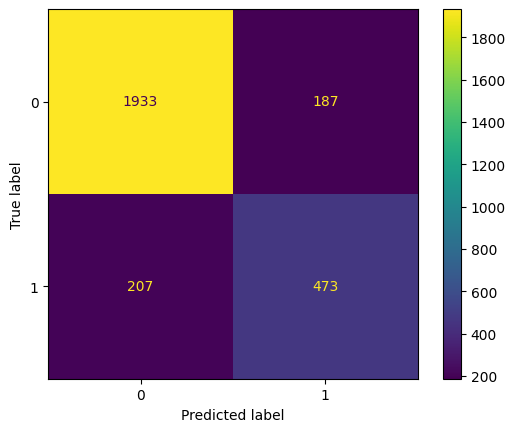


======== Epoch 1 / 4 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:10.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Batch   120  of    613.    Elapsed: 0:00:32.
  Batch   160  of    613.    Elapsed: 0:00:42.
  Batch   200  of    613.    Elapsed: 0:00:53.
  Batch   240  of    613.    Elapsed: 0:01:04.
  Batch   280  of    613.    Elapsed: 0:01:15.
  Batch   320  of    613.    Elapsed: 0:01:25.
  Batch   360  of    613.    Elapsed: 0:01:36.
  Batch   400  of    613.    Elapsed: 0:01:47.
  Batch   440  of    613.    Elapsed: 0:01:58.
  Batch   480  of    613.    Elapsed: 0:02:09.
  Batch   520  of    613.    Elapsed: 0:02:20.
  Batch   560  of    613.    Elapsed: 0:02:30.
  Batch   600  of    613.    Elapsed: 0:02:41.

  Average training loss: 0.01
  Training epcoh took: 0:02:45

Running Validation...
  Accuracy: 0.84
  Validation Loss: 1.23
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Bat

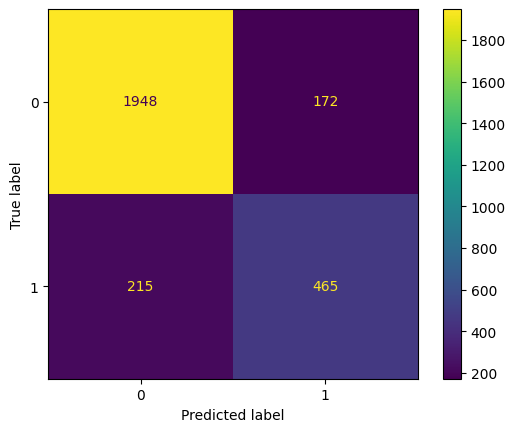


======== Epoch 1 / 5 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:22.
  Batch   120  of    613.    Elapsed: 0:00:33.
  Batch   160  of    613.    Elapsed: 0:00:44.
  Batch   200  of    613.    Elapsed: 0:00:55.
  Batch   240  of    613.    Elapsed: 0:01:06.
  Batch   280  of    613.    Elapsed: 0:01:18.
  Batch   320  of    613.    Elapsed: 0:01:29.
  Batch   360  of    613.    Elapsed: 0:01:40.
  Batch   400  of    613.    Elapsed: 0:01:51.
  Batch   440  of    613.    Elapsed: 0:02:02.
  Batch   480  of    613.    Elapsed: 0:02:13.
  Batch   520  of    613.    Elapsed: 0:02:24.
  Batch   560  of    613.    Elapsed: 0:02:36.
  Batch   600  of    613.    Elapsed: 0:02:48.

  Average training loss: 0.01
  Training epcoh took: 0:02:51

Running Validation...
  Accuracy: 0.86
  Validation Loss: 1.44
  Validation took: 0:00:08

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:22.
  Bat

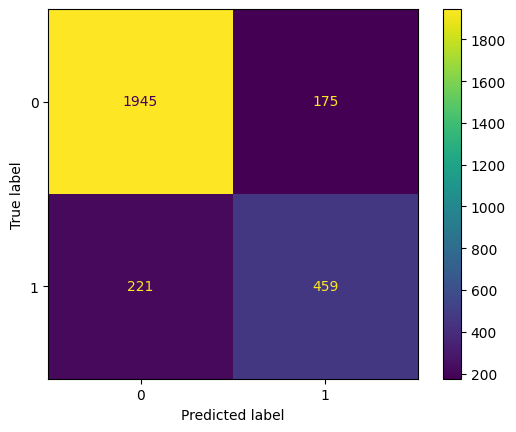


======== Epoch 1 / 2 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:22.
  Batch   120  of    613.    Elapsed: 0:00:34.
  Batch   160  of    613.    Elapsed: 0:00:45.
  Batch   200  of    613.    Elapsed: 0:00:56.
  Batch   240  of    613.    Elapsed: 0:01:08.
  Batch   280  of    613.    Elapsed: 0:01:20.
  Batch   320  of    613.    Elapsed: 0:01:31.
  Batch   360  of    613.    Elapsed: 0:01:42.
  Batch   400  of    613.    Elapsed: 0:01:54.
  Batch   440  of    613.    Elapsed: 0:02:05.
  Batch   480  of    613.    Elapsed: 0:02:17.
  Batch   520  of    613.    Elapsed: 0:02:29.
  Batch   560  of    613.    Elapsed: 0:02:41.
  Batch   600  of    613.    Elapsed: 0:02:52.

  Average training loss: 0.01
  Training epcoh took: 0:02:56

Running Validation...
  Accuracy: 0.85
  Validation Loss: 1.41
  Validation took: 0:00:08

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:23.
  Bat

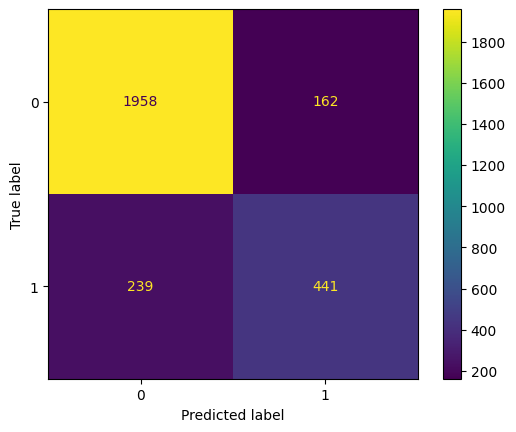


======== Epoch 1 / 4 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:23.
  Batch   120  of    613.    Elapsed: 0:00:34.
  Batch   160  of    613.    Elapsed: 0:00:46.
  Batch   200  of    613.    Elapsed: 0:00:58.
  Batch   240  of    613.    Elapsed: 0:01:10.
  Batch   280  of    613.    Elapsed: 0:01:22.
  Batch   320  of    613.    Elapsed: 0:01:33.
  Batch   360  of    613.    Elapsed: 0:01:45.
  Batch   400  of    613.    Elapsed: 0:01:57.
  Batch   440  of    613.    Elapsed: 0:02:09.
  Batch   480  of    613.    Elapsed: 0:02:21.
  Batch   520  of    613.    Elapsed: 0:02:33.
  Batch   560  of    613.    Elapsed: 0:02:45.
  Batch   600  of    613.    Elapsed: 0:02:57.

  Average training loss: 0.00
  Training epcoh took: 0:03:01

Running Validation...
  Accuracy: 0.84
  Validation Loss: 1.70
  Validation took: 0:00:08

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:12.
  Batch    80  of    613.    Elapsed: 0:00:23.
  Bat

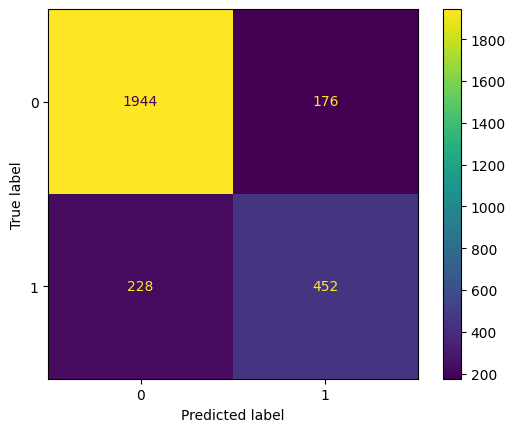


======== Epoch 1 / 5 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:14.
  Batch    80  of    613.    Elapsed: 0:00:28.
  Batch   120  of    613.    Elapsed: 0:00:43.
  Batch   160  of    613.    Elapsed: 0:00:57.
  Batch   200  of    613.    Elapsed: 0:01:09.
  Batch   240  of    613.    Elapsed: 0:01:20.
  Batch   280  of    613.    Elapsed: 0:01:31.
  Batch   320  of    613.    Elapsed: 0:01:43.
  Batch   360  of    613.    Elapsed: 0:01:57.
  Batch   400  of    613.    Elapsed: 0:02:11.
  Batch   440  of    613.    Elapsed: 0:02:25.
  Batch   480  of    613.    Elapsed: 0:02:40.
  Batch   520  of    613.    Elapsed: 0:02:55.
  Batch   560  of    613.    Elapsed: 0:03:07.
  Batch   600  of    613.    Elapsed: 0:03:18.

  Average training loss: 0.00
  Training epcoh took: 0:03:22

Running Validation...
  Accuracy: 0.87
  Validation Loss: 1.65
  Validation took: 0:00:08

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Bat

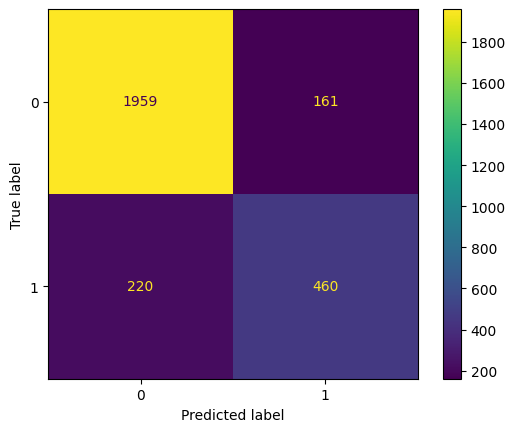


======== Epoch 1 / 2 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:22.
  Batch   120  of    613.    Elapsed: 0:00:34.
  Batch   160  of    613.    Elapsed: 0:00:45.
  Batch   200  of    613.    Elapsed: 0:00:56.
  Batch   240  of    613.    Elapsed: 0:01:06.
  Batch   280  of    613.    Elapsed: 0:01:17.
  Batch   320  of    613.    Elapsed: 0:01:27.
  Batch   360  of    613.    Elapsed: 0:01:38.
  Batch   400  of    613.    Elapsed: 0:01:49.
  Batch   440  of    613.    Elapsed: 0:01:59.
  Batch   480  of    613.    Elapsed: 0:02:10.
  Batch   520  of    613.    Elapsed: 0:02:20.
  Batch   560  of    613.    Elapsed: 0:02:31.
  Batch   600  of    613.    Elapsed: 0:02:42.

  Average training loss: 0.02
  Training epcoh took: 0:02:46

Running Validation...
  Accuracy: 0.86
  Validation Loss: 1.31
  Validation took: 0:00:07

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:10.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Bat

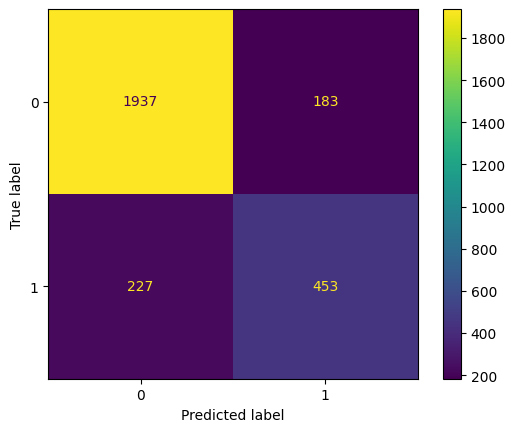


======== Epoch 1 / 4 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:10.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Batch   120  of    613.    Elapsed: 0:00:32.
  Batch   160  of    613.    Elapsed: 0:00:42.
  Batch   200  of    613.    Elapsed: 0:00:53.
  Batch   240  of    613.    Elapsed: 0:01:03.
  Batch   280  of    613.    Elapsed: 0:01:14.
  Batch   320  of    613.    Elapsed: 0:01:24.
  Batch   360  of    613.    Elapsed: 0:01:35.
  Batch   400  of    613.    Elapsed: 0:01:46.
  Batch   440  of    613.    Elapsed: 0:01:56.
  Batch   480  of    613.    Elapsed: 0:02:07.
  Batch   520  of    613.    Elapsed: 0:02:17.
  Batch   560  of    613.    Elapsed: 0:02:28.
  Batch   600  of    613.    Elapsed: 0:02:39.

  Average training loss: 0.03
  Training epcoh took: 0:02:42

Running Validation...
  Accuracy: 0.86
  Validation Loss: 1.13
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:10.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Bat

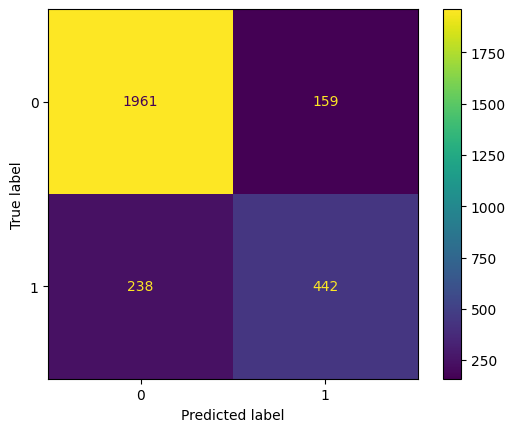


======== Epoch 1 / 5 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Batch   120  of    613.    Elapsed: 0:00:32.
  Batch   160  of    613.    Elapsed: 0:00:43.
  Batch   200  of    613.    Elapsed: 0:00:54.
  Batch   240  of    613.    Elapsed: 0:01:04.
  Batch   280  of    613.    Elapsed: 0:01:15.
  Batch   320  of    613.    Elapsed: 0:01:26.
  Batch   360  of    613.    Elapsed: 0:01:36.
  Batch   400  of    613.    Elapsed: 0:01:47.
  Batch   440  of    613.    Elapsed: 0:01:58.
  Batch   480  of    613.    Elapsed: 0:02:09.
  Batch   520  of    613.    Elapsed: 0:02:19.
  Batch   560  of    613.    Elapsed: 0:02:30.
  Batch   600  of    613.    Elapsed: 0:02:41.

  Average training loss: 0.02
  Training epcoh took: 0:02:44

Running Validation...
  Accuracy: 0.85
  Validation Loss: 1.43
  Validation took: 0:00:07

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Bat

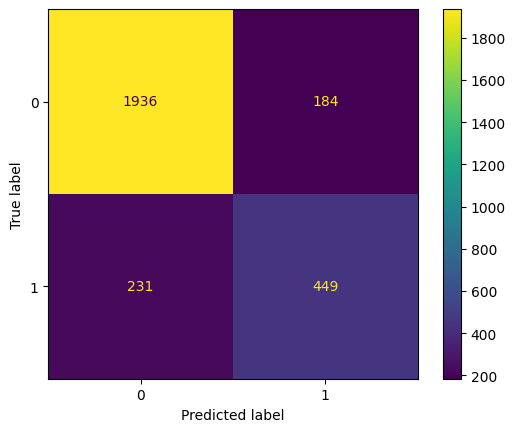


======== Epoch 1 / 2 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:22.
  Batch   120  of    613.    Elapsed: 0:00:32.
  Batch   160  of    613.    Elapsed: 0:00:43.
  Batch   200  of    613.    Elapsed: 0:00:54.
  Batch   240  of    613.    Elapsed: 0:01:05.
  Batch   280  of    613.    Elapsed: 0:01:15.
  Batch   320  of    613.    Elapsed: 0:01:26.
  Batch   360  of    613.    Elapsed: 0:01:37.
  Batch   400  of    613.    Elapsed: 0:01:48.
  Batch   440  of    613.    Elapsed: 0:01:59.
  Batch   480  of    613.    Elapsed: 0:02:09.
  Batch   520  of    613.    Elapsed: 0:02:21.
  Batch   560  of    613.    Elapsed: 0:02:32.
  Batch   600  of    613.    Elapsed: 0:02:43.

  Average training loss: 0.02
  Training epcoh took: 0:02:46

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.95
  Validation took: 0:00:07

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:24.
  Bat

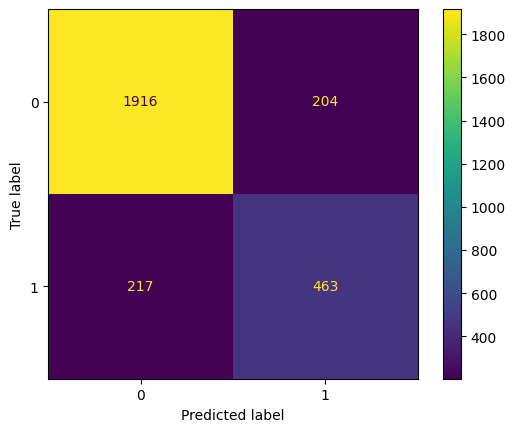


======== Epoch 1 / 4 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Batch   120  of    613.    Elapsed: 0:00:32.
  Batch   160  of    613.    Elapsed: 0:00:43.
  Batch   200  of    613.    Elapsed: 0:00:53.
  Batch   240  of    613.    Elapsed: 0:01:04.
  Batch   280  of    613.    Elapsed: 0:01:15.
  Batch   320  of    613.    Elapsed: 0:01:26.
  Batch   360  of    613.    Elapsed: 0:01:36.
  Batch   400  of    613.    Elapsed: 0:01:47.
  Batch   440  of    613.    Elapsed: 0:01:58.
  Batch   480  of    613.    Elapsed: 0:02:09.
  Batch   520  of    613.    Elapsed: 0:02:20.
  Batch   560  of    613.    Elapsed: 0:02:31.
  Batch   600  of    613.    Elapsed: 0:02:41.

  Average training loss: 0.01
  Training epcoh took: 0:02:45

Running Validation...
  Accuracy: 0.86
  Validation Loss: 1.25
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Bat

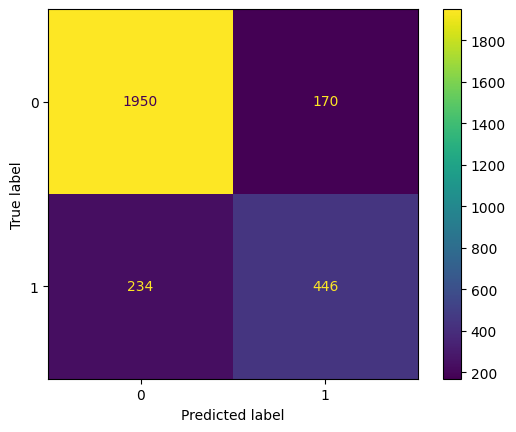


======== Epoch 1 / 5 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Batch   120  of    613.    Elapsed: 0:00:32.
  Batch   160  of    613.    Elapsed: 0:00:43.
  Batch   200  of    613.    Elapsed: 0:00:54.
  Batch   240  of    613.    Elapsed: 0:01:04.
  Batch   280  of    613.    Elapsed: 0:01:15.
  Batch   320  of    613.    Elapsed: 0:01:26.
  Batch   360  of    613.    Elapsed: 0:01:36.
  Batch   400  of    613.    Elapsed: 0:01:47.
  Batch   440  of    613.    Elapsed: 0:01:58.
  Batch   480  of    613.    Elapsed: 0:02:08.
  Batch   520  of    613.    Elapsed: 0:02:19.
  Batch   560  of    613.    Elapsed: 0:02:30.
  Batch   600  of    613.    Elapsed: 0:02:40.

  Average training loss: 0.01
  Training epcoh took: 0:02:44

Running Validation...
  Accuracy: 0.86
  Validation Loss: 1.39
  Validation took: 0:00:07

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Bat

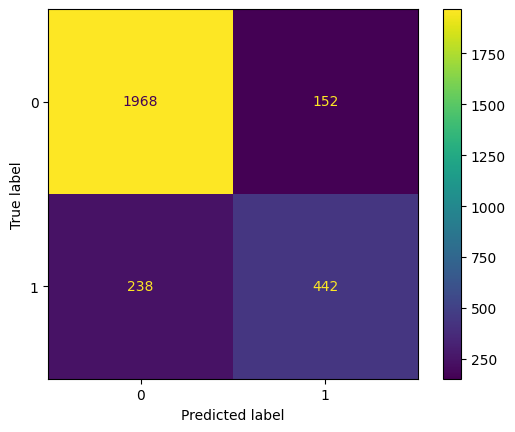


======== Epoch 1 / 2 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Batch   120  of    613.    Elapsed: 0:00:32.
  Batch   160  of    613.    Elapsed: 0:00:42.
  Batch   200  of    613.    Elapsed: 0:00:53.
  Batch   240  of    613.    Elapsed: 0:01:04.
  Batch   280  of    613.    Elapsed: 0:01:14.
  Batch   320  of    613.    Elapsed: 0:01:25.
  Batch   360  of    613.    Elapsed: 0:01:35.
  Batch   400  of    613.    Elapsed: 0:01:46.
  Batch   440  of    613.    Elapsed: 0:01:57.
  Batch   480  of    613.    Elapsed: 0:02:07.
  Batch   520  of    613.    Elapsed: 0:02:18.
  Batch   560  of    613.    Elapsed: 0:02:29.
  Batch   600  of    613.    Elapsed: 0:02:39.

  Average training loss: 0.04
  Training epcoh took: 0:02:43

Running Validation...
  Accuracy: 0.85
  Validation Loss: 1.22
  Validation took: 0:00:08

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:23.
  Bat

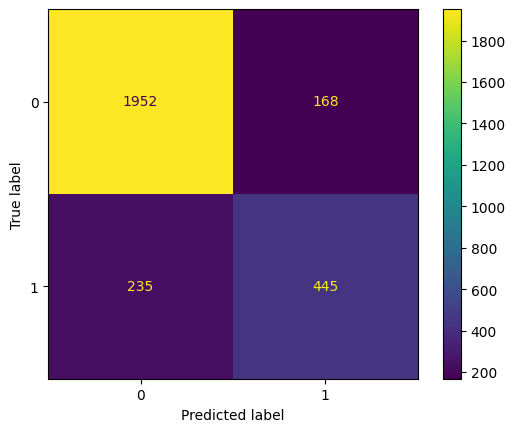


======== Epoch 1 / 4 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:10.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Batch   120  of    613.    Elapsed: 0:00:32.
  Batch   160  of    613.    Elapsed: 0:00:43.
  Batch   200  of    613.    Elapsed: 0:00:53.
  Batch   240  of    613.    Elapsed: 0:01:04.
  Batch   280  of    613.    Elapsed: 0:01:15.
  Batch   320  of    613.    Elapsed: 0:01:26.
  Batch   360  of    613.    Elapsed: 0:01:36.
  Batch   400  of    613.    Elapsed: 0:01:47.
  Batch   440  of    613.    Elapsed: 0:01:58.
  Batch   480  of    613.    Elapsed: 0:02:08.
  Batch   520  of    613.    Elapsed: 0:02:19.
  Batch   560  of    613.    Elapsed: 0:02:30.
  Batch   600  of    613.    Elapsed: 0:02:40.

  Average training loss: 0.07
  Training epcoh took: 0:02:44

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.95
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Bat

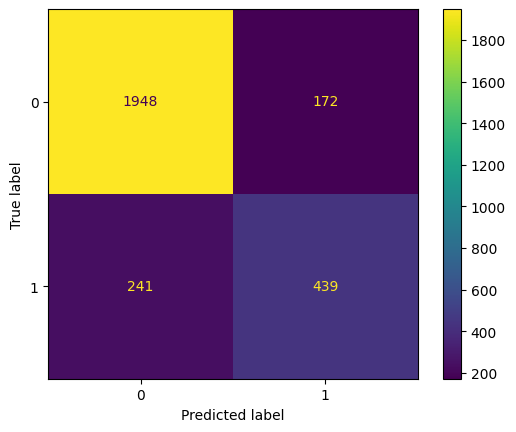


======== Epoch 1 / 5 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Batch   120  of    613.    Elapsed: 0:00:32.
  Batch   160  of    613.    Elapsed: 0:00:43.
  Batch   200  of    613.    Elapsed: 0:00:54.
  Batch   240  of    613.    Elapsed: 0:01:04.
  Batch   280  of    613.    Elapsed: 0:01:15.
  Batch   320  of    613.    Elapsed: 0:01:26.
  Batch   360  of    613.    Elapsed: 0:01:37.
  Batch   400  of    613.    Elapsed: 0:01:48.
  Batch   440  of    613.    Elapsed: 0:01:59.
  Batch   480  of    613.    Elapsed: 0:02:10.
  Batch   520  of    613.    Elapsed: 0:02:21.
  Batch   560  of    613.    Elapsed: 0:02:32.
  Batch   600  of    613.    Elapsed: 0:02:43.

  Average training loss: 0.04
  Training epcoh took: 0:02:46

Running Validation...
  Accuracy: 0.87
  Validation Loss: 1.01
  Validation took: 0:00:07

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:22.
  Bat

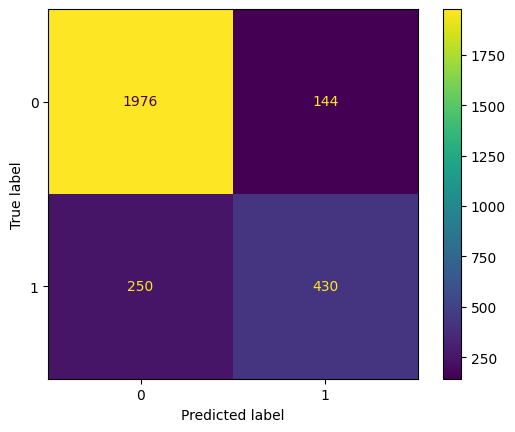


======== Epoch 1 / 2 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:22.
  Batch   120  of    613.    Elapsed: 0:00:33.
  Batch   160  of    613.    Elapsed: 0:00:44.
  Batch   200  of    613.    Elapsed: 0:00:57.
  Batch   240  of    613.    Elapsed: 0:01:09.
  Batch   280  of    613.    Elapsed: 0:01:20.
  Batch   320  of    613.    Elapsed: 0:01:31.
  Batch   360  of    613.    Elapsed: 0:01:42.
  Batch   400  of    613.    Elapsed: 0:01:53.
  Batch   440  of    613.    Elapsed: 0:02:04.
  Batch   480  of    613.    Elapsed: 0:02:14.
  Batch   520  of    613.    Elapsed: 0:02:25.
  Batch   560  of    613.    Elapsed: 0:02:36.
  Batch   600  of    613.    Elapsed: 0:02:47.

  Average training loss: 0.03
  Training epcoh took: 0:02:50

Running Validation...
  Accuracy: 0.83
  Validation Loss: 1.33
  Validation took: 0:00:07

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:21.
  Bat

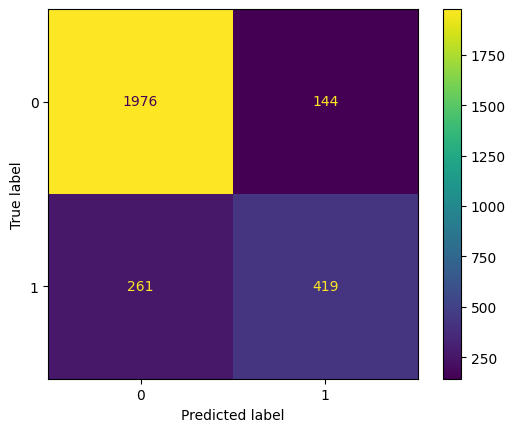


======== Epoch 1 / 4 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:22.
  Batch   120  of    613.    Elapsed: 0:00:32.
  Batch   160  of    613.    Elapsed: 0:00:43.
  Batch   200  of    613.    Elapsed: 0:00:54.
  Batch   240  of    613.    Elapsed: 0:01:05.
  Batch   280  of    613.    Elapsed: 0:01:15.
  Batch   320  of    613.    Elapsed: 0:01:26.
  Batch   360  of    613.    Elapsed: 0:01:37.
  Batch   400  of    613.    Elapsed: 0:01:48.
  Batch   440  of    613.    Elapsed: 0:01:59.
  Batch   480  of    613.    Elapsed: 0:02:09.
  Batch   520  of    613.    Elapsed: 0:02:20.
  Batch   560  of    613.    Elapsed: 0:02:31.
  Batch   600  of    613.    Elapsed: 0:02:42.

  Average training loss: 0.03
  Training epcoh took: 0:02:45

Running Validation...
  Accuracy: 0.84
  Validation Loss: 1.07
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:22.
  Bat

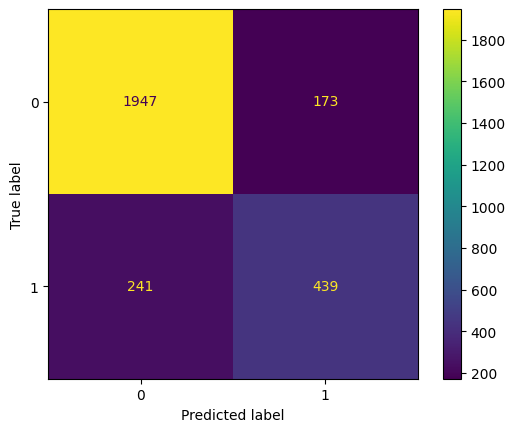


======== Epoch 1 / 5 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:22.
  Batch   120  of    613.    Elapsed: 0:00:33.
  Batch   160  of    613.    Elapsed: 0:00:43.
  Batch   200  of    613.    Elapsed: 0:00:54.
  Batch   240  of    613.    Elapsed: 0:01:05.
  Batch   280  of    613.    Elapsed: 0:01:16.
  Batch   320  of    613.    Elapsed: 0:01:27.
  Batch   360  of    613.    Elapsed: 0:01:38.
  Batch   400  of    613.    Elapsed: 0:01:49.
  Batch   440  of    613.    Elapsed: 0:01:59.
  Batch   480  of    613.    Elapsed: 0:02:10.
  Batch   520  of    613.    Elapsed: 0:02:21.
  Batch   560  of    613.    Elapsed: 0:02:32.
  Batch   600  of    613.    Elapsed: 0:02:43.

  Average training loss: 0.02
  Training epcoh took: 0:02:47

Running Validation...
  Accuracy: 0.84
  Validation Loss: 1.38
  Validation took: 0:00:08

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    613.    Elapsed: 0:00:11.
  Batch    80  of    613.    Elapsed: 0:00:22.
  Bat

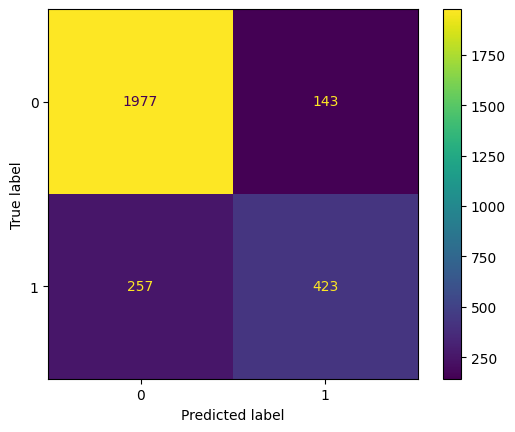


======== Epoch 1 / 2 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    307.    Elapsed: 0:00:20.
  Batch    80  of    307.    Elapsed: 0:00:40.
  Batch   120  of    307.    Elapsed: 0:01:00.
  Batch   160  of    307.    Elapsed: 0:01:20.
  Batch   200  of    307.    Elapsed: 0:01:40.
  Batch   240  of    307.    Elapsed: 0:02:01.
  Batch   280  of    307.    Elapsed: 0:02:21.

  Average training loss: 0.01
  Training epcoh took: 0:02:34

Running Validation...
  Accuracy: 0.84
  Validation Loss: 1.31
  Validation took: 0:00:08

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    307.    Elapsed: 0:00:20.
  Batch    80  of    307.    Elapsed: 0:00:39.
  Batch   120  of    307.    Elapsed: 0:00:59.
  Batch   160  of    307.    Elapsed: 0:01:22.
  Batch   200  of    307.    Elapsed: 0:01:43.
  Batch   240  of    307.    Elapsed: 0:02:04.
  Batch   280  of    307.    Elapsed: 0:02:26.

  Average training loss: 0.01
  Training epcoh took: 0:02:40

Running Validation...
  Accuracy: 0.85
  Validation Loss: 1.24
  Validation took: 0

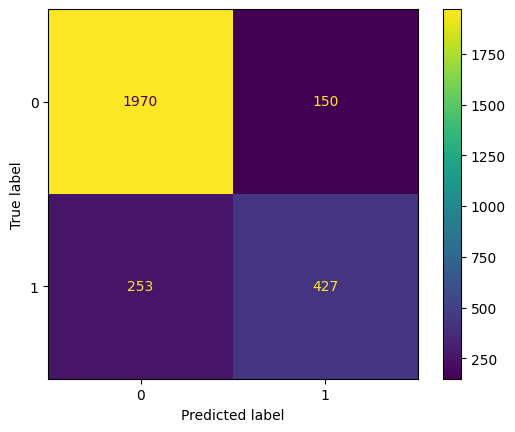


======== Epoch 1 / 4 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    307.    Elapsed: 0:00:23.
  Batch    80  of    307.    Elapsed: 0:00:43.
  Batch   120  of    307.    Elapsed: 0:01:03.
  Batch   160  of    307.    Elapsed: 0:01:23.
  Batch   200  of    307.    Elapsed: 0:01:43.
  Batch   240  of    307.    Elapsed: 0:02:03.
  Batch   280  of    307.    Elapsed: 0:02:24.

  Average training loss: 0.01
  Training epcoh took: 0:02:37

Running Validation...
  Accuracy: 0.84
  Validation Loss: 1.23
  Validation took: 0:00:08

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    307.    Elapsed: 0:00:20.
  Batch    80  of    307.    Elapsed: 0:00:40.
  Batch   120  of    307.    Elapsed: 0:01:00.
  Batch   160  of    307.    Elapsed: 0:01:20.
  Batch   200  of    307.    Elapsed: 0:01:40.
  Batch   240  of    307.    Elapsed: 0:01:59.
  Batch   280  of    307.    Elapsed: 0:02:19.

  Average training loss: 0.00
  Training epcoh took: 0:02:32

Running Validation...
  Accuracy: 0.85
  Validation Loss: 1.20
  Validation took: 0

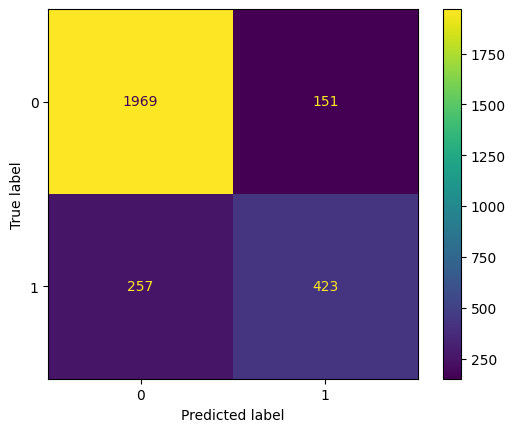


======== Epoch 1 / 5 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    307.    Elapsed: 0:00:22.
  Batch    80  of    307.    Elapsed: 0:00:43.
  Batch   120  of    307.    Elapsed: 0:01:04.
  Batch   160  of    307.    Elapsed: 0:01:26.
  Batch   200  of    307.    Elapsed: 0:01:48.
  Batch   240  of    307.    Elapsed: 0:02:09.
  Batch   280  of    307.    Elapsed: 0:02:31.

  Average training loss: 0.00
  Training epcoh took: 0:02:45

Running Validation...
  Accuracy: 0.85
  Validation Loss: 1.79
  Validation took: 0:00:08

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    307.    Elapsed: 0:00:22.
  Batch    80  of    307.    Elapsed: 0:00:43.
  Batch   120  of    307.    Elapsed: 0:01:05.
  Batch   160  of    307.    Elapsed: 0:01:26.
  Batch   200  of    307.    Elapsed: 0:01:48.
  Batch   240  of    307.    Elapsed: 0:02:09.
  Batch   280  of    307.    Elapsed: 0:02:31.

  Average training loss: 0.00
  Training epcoh took: 0:02:45

Running Validation...
  Accuracy: 0.85
  Validation Loss: 1.79
  Validation took: 0

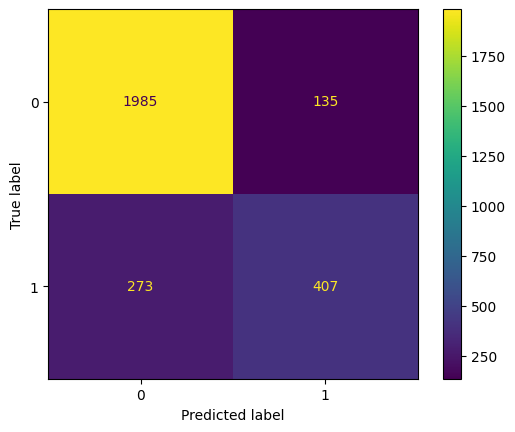


======== Epoch 1 / 2 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    307.    Elapsed: 0:00:22.
  Batch    80  of    307.    Elapsed: 0:00:44.
  Batch   120  of    307.    Elapsed: 0:01:05.
  Batch   160  of    307.    Elapsed: 0:01:27.
  Batch   200  of    307.    Elapsed: 0:01:49.
  Batch   240  of    307.    Elapsed: 0:02:11.
  Batch   280  of    307.    Elapsed: 0:02:33.

  Average training loss: 0.00
  Training epcoh took: 0:02:49

Running Validation...
  Accuracy: 0.85
  Validation Loss: 2.02
  Validation took: 0:00:10

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    307.    Elapsed: 0:00:37.
  Batch    80  of    307.    Elapsed: 0:00:58.
  Batch   120  of    307.    Elapsed: 0:01:20.
  Batch   160  of    307.    Elapsed: 0:01:42.
  Batch   200  of    307.    Elapsed: 0:02:04.
  Batch   240  of    307.    Elapsed: 0:02:26.
  Batch   280  of    307.    Elapsed: 0:02:47.

  Average training loss: 0.00
  Training epcoh took: 0:03:01

Running Validation...
  Accuracy: 0.85
  Validation Loss: 2.20
  Validation took: 0

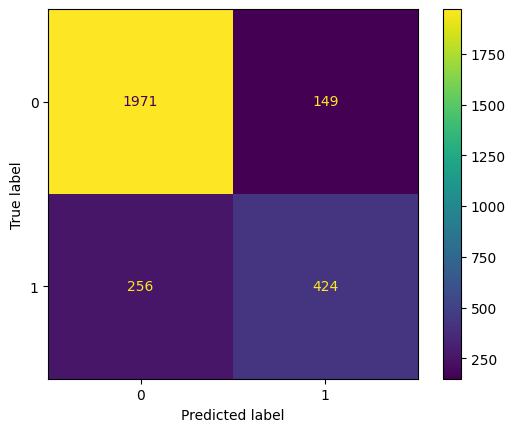


======== Epoch 1 / 4 ========
Training...


C:\Users\Antonio\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    307.    Elapsed: 0:00:22.
  Batch    80  of    307.    Elapsed: 0:00:44.
  Batch   120  of    307.    Elapsed: 0:01:06.
  Batch   160  of    307.    Elapsed: 0:01:29.
  Batch   200  of    307.    Elapsed: 0:01:51.
  Batch   240  of    307.    Elapsed: 0:02:14.
  Batch   280  of    307.    Elapsed: 0:02:35.

  Average training loss: 0.00
  Training epcoh took: 0:02:50

Running Validation...
  Accuracy: 0.84
  Validation Loss: 2.32
  Validation took: 0:00:08

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    307.    Elapsed: 0:00:23.


KeyboardInterrupt: 

In [14]:
batch_sizes = [16, 32, 64]
learning_rate = [1e-5, 2e-5, 5e-5]
warmup_steps = [0, 500]
num_epochs = [2, 4, 5]

for bat in batch_sizes:
    for lear in learning_rate:
        for warmup in warmup_steps:
            for epoh in num_epochs:

                # The DataLoader needs to know our batch size for training, so we specify it 
                # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
                # size of 16 or 32.
                batch_size = bat

                # Create the DataLoaders for our training and validation sets.
                # We'll take training samples in random order. 
                train_dataloader = DataLoader(
                            dataset["train"],  # The training samples.
                            sampler = RandomSampler(dataset["train"]), # Select batches randomly
                            batch_size = batch_size # Trains with this batch size.
                        )

                # For validation the order doesn't matter, so we'll just read them sequentially.
                validation_dataloader = DataLoader(
                            dataset["valid"], # The validation samples.
                            sampler = SequentialSampler(dataset["valid"]), # Pull out batches sequentially.
                            batch_size = batch_size # Evaluate with this batch size.
                        )

                test_dataloader = DataLoader(
                            dataset["test"],
                            sampler = SequentialSampler(dataset["test"]),
                            batch_size = batch_size
                )
                
                
                optimizer = AdamW(model2.parameters(),
                  lr = lear, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
                
                
                epochs = epoh
                total_steps = len(train_dataloader) * epochs
                scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup, # Default value in run_glue.py
                                            num_training_steps = total_steps)
                
                
                seed_val = 42
                random.seed(seed_val)
                np.random.seed(seed_val)
                torch.manual_seed(seed_val)
                torch.cuda.manual_seed_all(seed_val)

                training_stats = []
                total_t0 = time.time()

                for epoch_i in range(0, epochs):

                    print("")
                    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
                    print('Training...')

                    t0 = time.time()

                    total_train_loss = 0

                    model2.train()

                    for step, batch in enumerate(train_dataloader):

                        # Progress update every 40 batches.
                        if step % 40 == 0 and not step == 0:
                            elapsed = format_time(time.time() - t0)

                            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

                        b_input_ids = batch[0].to(device)
                        b_input_mask = batch[1].to(device)
                        b_labels = batch[2].to(device)

                        model2.zero_grad()        

                        temp = model2(b_input_ids, 
                                             token_type_ids=None, 
                                             attention_mask=b_input_mask, 
                                             labels=b_labels)
                        loss = temp.loss
                        logits = temp.logits 

                        total_train_loss += loss.item()

                        loss.backward()

                        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)

                        optimizer.step()

                        scheduler.step()

                    avg_train_loss = total_train_loss / len(train_dataloader)            

                    training_time = format_time(time.time() - t0)

                    print("")
                    print("  Average training loss: {0:.2f}".format(avg_train_loss))
                    print("  Training epcoh took: {:}".format(training_time))

                    print("")
                    print("Running Validation...")

                    t0 = time.time()

                    model2.eval()

                    total_eval_accuracy = 0
                    total_eval_loss = 0
                    nb_eval_steps = 0

                    for batch in validation_dataloader:

                        b_input_ids = batch[0].to(device)
                        b_input_mask = batch[1].to(device)
                        b_labels = batch[2].to(device)

                        with torch.no_grad():        

                            temp = model2(b_input_ids, 
                                                   token_type_ids=None, 
                                                   attention_mask=b_input_mask,
                                                   labels=b_labels)
                            loss = temp.loss
                            logits = temp.logits

                        total_eval_loss += loss.item()

                        logits = logits.detach().cpu().numpy()
                        label_ids = b_labels.to('cpu').numpy()

                        total_eval_accuracy += flat_accuracy(logits, label_ids)

                    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
                    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

                    avg_val_loss = total_eval_loss / len(validation_dataloader)

                    validation_time = format_time(time.time() - t0)

                    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
                    print("  Validation took: {:}".format(validation_time))

                    training_stats.append(
                        {
                            'epoch': epoch_i + 1,
                            'Training Loss': avg_train_loss,
                            'Valid. Loss': avg_val_loss,
                            'Valid. Accur.': avg_val_accuracy,
                            'Training Time': training_time,
                            'Validation Time': validation_time
                        }
                    )

                print("")
                print("Training complete!")
                print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
                
                
                # Prediction on test set

                print('Predicting labels for {:,} test sentences...'.format(len(input_ids["test"])))

                # Put model in evaluation mode
                model2.eval()

                # Tracking variables 
                predictions , true_labels = [], []

                # Predict 
                for batch in test_dataloader:
                  # Add batch to GPU
                  batch = tuple(t.to(device) for t in batch)

                  # Unpack the inputs from our dataloader
                  b_input_ids, b_input_mask, b_labels = batch

                  # Telling the model not to compute or store gradients, saving memory and 
                  # speeding up prediction
                  with torch.no_grad():
                      # Forward pass, calculate logit predictions
                      outputs = model2(b_input_ids, token_type_ids=None, 
                                      attention_mask=b_input_mask)

                  logits = outputs[0]

                  # Move logits and labels to CPU
                  logits = logits.detach().cpu().numpy()
                  label_ids = b_labels.to('cpu').numpy()

                  # Store predictions and true labels
                  predictions.append(logits)
                  true_labels.append(label_ids)

                print('    DONE.')
                
                
                y_pred = []
                for i in predictions:
                    for j in np.argmax(i, axis=1).flatten():
                        y_pred.append(j)
                y_test = []
                for i in true_labels:
                    for j in i:
                        y_test.append(j)
                        
                evaluate(y_test, y_pred)